In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# 1. Loading The Dataset

In [2]:
t_data= pd.read_csv('train.csv',index_col=0)
test= pd.read_csv('test.csv',index_col=0)

In [3]:
t_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Inspecting if the Dataset contains Null values

In [5]:
t_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
t_data['Total_area']=t_data['1stFlrSF']+t_data['2ndFlrSF']+t_data['TotalBsmtSF']
t_data.shape

(1460, 81)

In [7]:
test['Total_area']=test['1stFlrSF']+test['2ndFlrSF']+test['TotalBsmtSF']
test.shape

(1459, 80)

# 2. Outlier Detection and Removal

In [8]:
a=t_data.columns
a.shape

(81,)

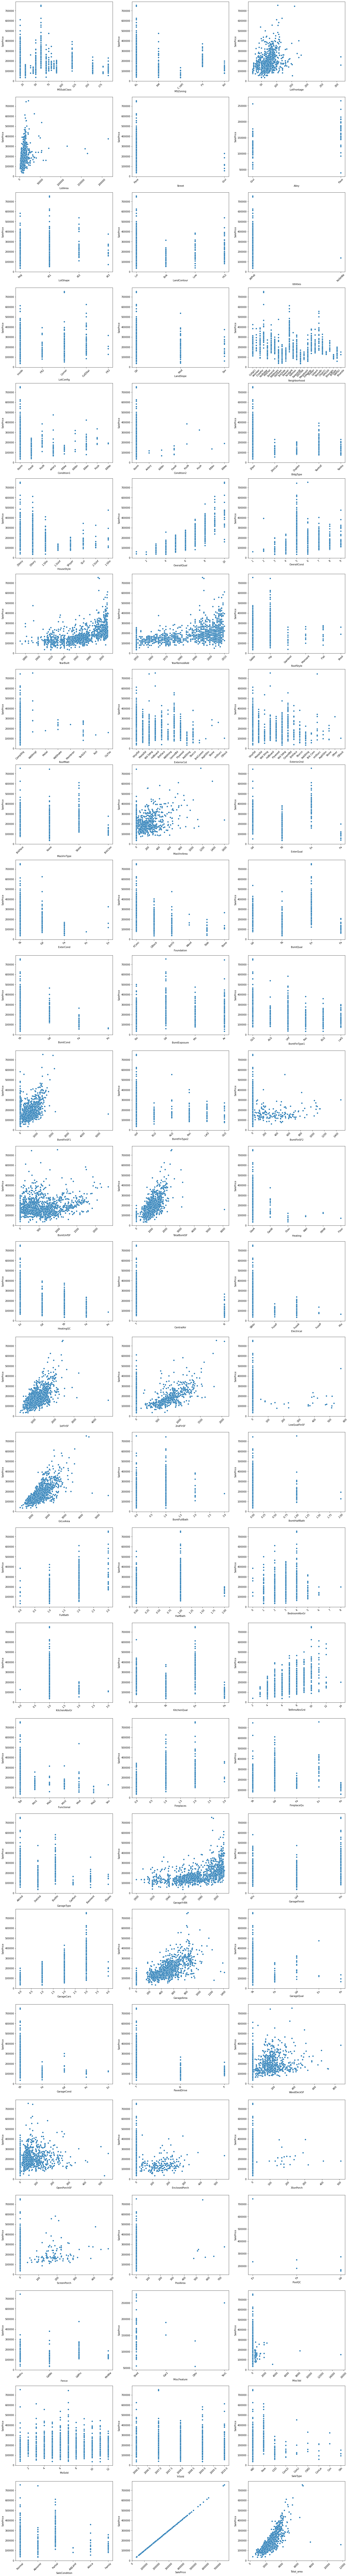

In [9]:
plt.figure(figsize=(25,600))
for i, data in enumerate(list(a), 1):
    plt.subplot(len(list(a)), 3, i)
    sns.scatterplot(x=data, y='SalePrice', palette='Blues', data=t_data)
    plt.xticks(rotation=45)

### From the above graphs it's clear that some of the Features have outliers or have null values or are zero.

Let's remove some outliers and continue with preprocessing

In [10]:
lot_frontage_outlier = t_data[t_data["LotFrontage"]>250].index
t_data.drop(index = lot_frontage_outlier, inplace=True)
print(t_data.shape)

(1458, 81)


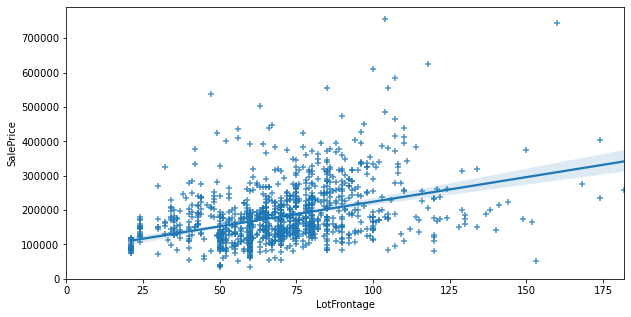

In [11]:
plt.figure(figsize=(10,5))
sns.regplot(x= t_data["LotFrontage"], y = t_data["SalePrice"], marker= "+")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [12]:
x=t_data[(t_data['GrLivArea']>=4000) & (t_data['SalePrice']<=300000)].index
t_data.drop(index = x, inplace=True)
print(x)
print(t_data.shape)

Int64Index([524], dtype='int64', name='Id')
(1457, 81)


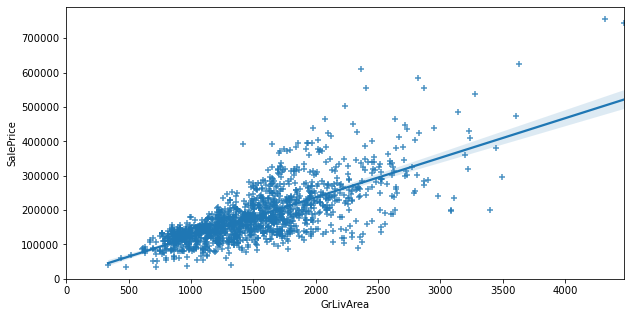

In [13]:
plt.figure(figsize=(10,5))
sns.regplot(x=t_data['GrLivArea'],y=t_data['SalePrice'],marker='+')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

 The above Three data points seem to be the outliers in data and have been removed accordingly

# 3. Correlation as a metric for removing similar features. 

<AxesSubplot:>

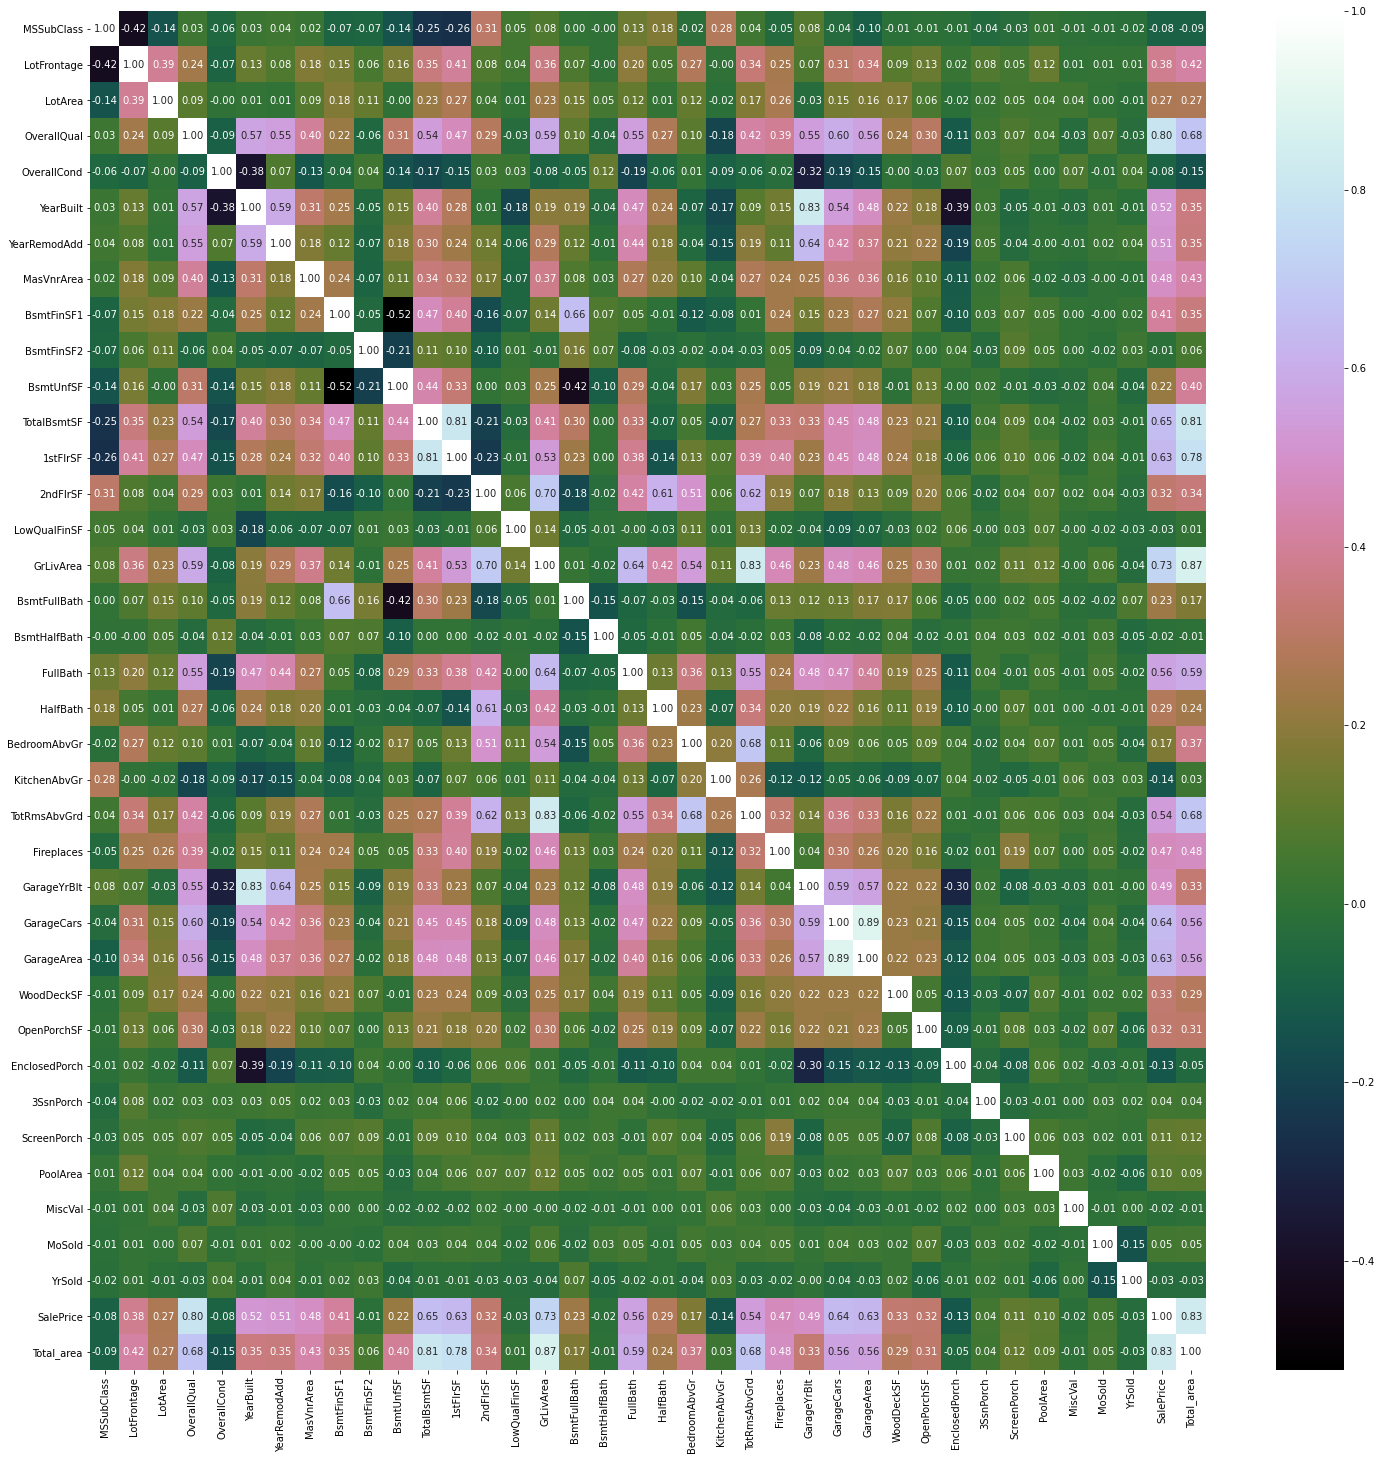

In [14]:
plt.figure(figsize=(25,25))
a=t_data.corr()
sns.heatmap(a, annot=True,cmap="cubehelix",fmt='.2f')

There is no way to manually remove all the similar features so setting a arbitary value of 0.8 to remove similar features (Not setting a negative side as minimum value lies around -0.5) 

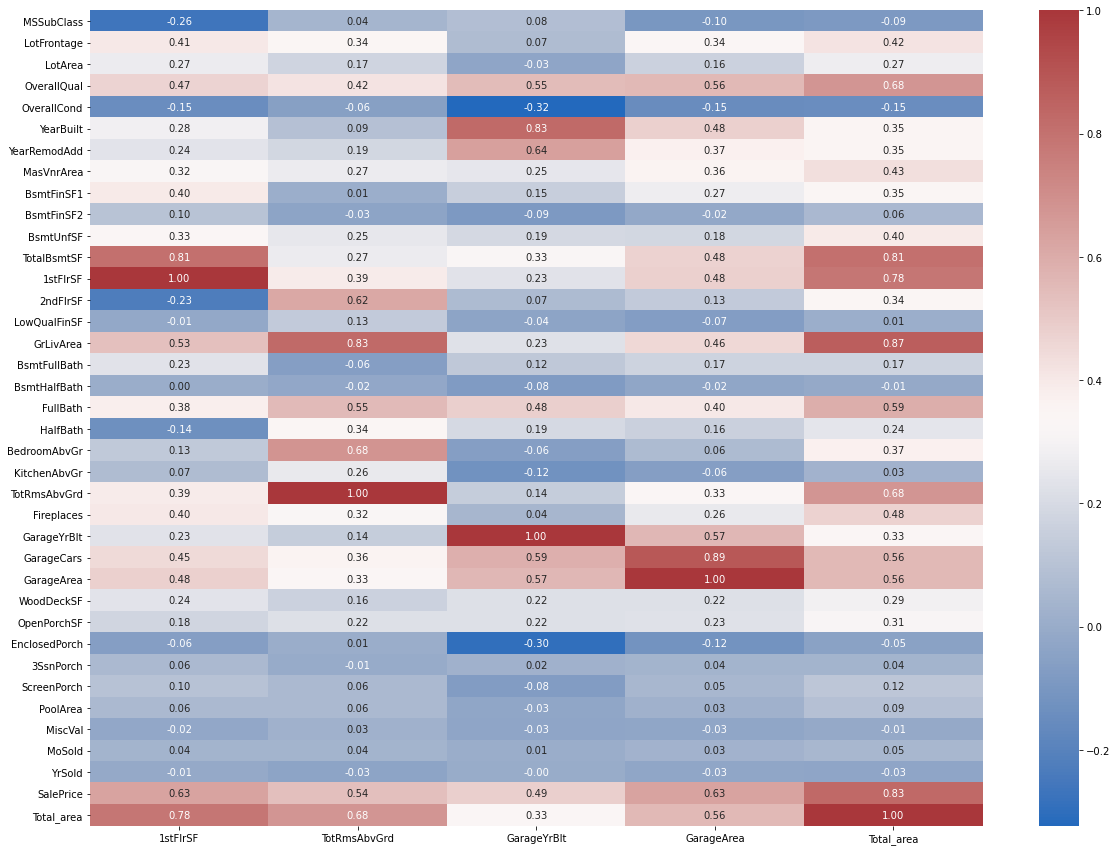

In [15]:
columns = np.full((a.shape[0],), True, dtype=bool)
for i in range(a.shape[0]):
    for j in range(i+1, a.shape[0]):
        if a.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = a.columns[~columns]
data1 = a[selected_columns]

plt.figure(figsize=(20,15))
sns.heatmap(data1, annot=True, fmt='.2f', cmap='vlag')
plt.show()

In [16]:
a=data1.columns
a=a[1:-1]
print(a)
t_data.drop(a,axis=1, inplace=True)
print(t_data.shape)

Index(['TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea'], dtype='object')
(1457, 78)


In [17]:
test.drop(a,axis=1, inplace=True)
test.shape

(1459, 77)

# 4. Transforming the Target Distribution

C:\Users\Shukla\.conda\envs\Python3.7\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


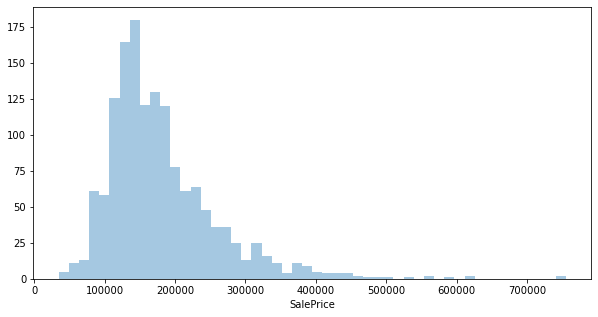

Skewness : 1.8830684855553144
Kutrosis : 6.528012973216978


In [18]:
plt.figure(figsize=(10,5))
sns.distplot(t_data.SalePrice, norm_hist=False,hist=True,kde=False, bins=50)
plt.show()
print("Skewness :",t_data.SalePrice.skew())
print("Kutrosis :",t_data.SalePrice.kurt())

In [19]:
t_data.SalePrice= np.log1p(t_data.SalePrice)

In [20]:
from scipy.stats import norm
(mu, sigma) = norm.fit(t_data['SalePrice'])

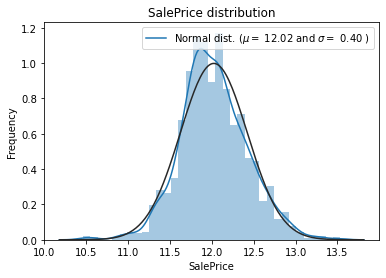

In [21]:
sns.distplot(t_data.SalePrice, norm_hist=False,hist=True,kde=True, fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

In [22]:
y_target=t_data.SalePrice
t_data.drop('SalePrice', axis=1,inplace=True)
t_data.shape

(1457, 77)

# 5. Feature Transformation and filling null values

Concatnating the test and train data to be able to work with Numerical and Categorical colums and to transform them easily

In [23]:
all_data= pd.concat([t_data,test])
print(all_data.shape)
categorical_cols=[cname for cname in all_data.columns if all_data[cname].nunique()<30 and all_data[cname].dtype=='object']
numerical_cols=[cname for cname in t_data.columns if t_data[cname].dtype in ['int64','float64']]

my_cols=categorical_cols+numerical_cols
x=all_data[my_cols].copy() # creating a copy
print(x.shape)

(2916, 77)
(2916, 77)


### Checking for Null Values

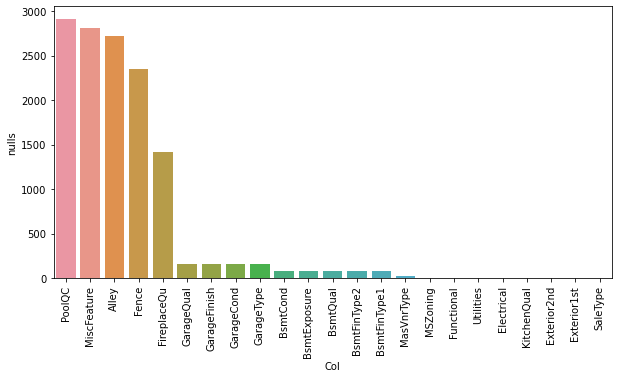

In [26]:
vals = []
col  = []
#null_dict["features"]= {}
for colm in categorical_cols:
    ab = x[colm].value_counts(dropna = False)
    if x[colm].isnull().sum()!= 0:
        vals.append(ab.loc[ab.index.isnull()][0])
        col.append(colm)
null_values = pd.DataFrame({'Col': col,'nulls' :vals}, index= None)
null_values.sort_values(by= "nulls", ascending=False, inplace= True)

plt.figure(figsize=(10,5))
sns.barplot(x= "Col", y = "nulls", data = null_values)
plt.xticks(rotation=90)
plt.show()

In [27]:
all_data['PoolQC']= all_data['PoolQC'].fillna('None')

for col in ('Fence', 'MiscFeature'):
    all_data[col] = all_data[col].fillna('None')
    
all_data['Alley']= all_data['Alley'].fillna('None')

all_data['FireplaceQu']= all_data['FireplaceQu'].fillna('None')
all_data['GarageQual']= all_data['GarageQual'].fillna('None')
all_data['GarageFinish']= all_data['GarageFinish'].fillna('None')
all_data['GarageCond']= all_data['GarageCond'].fillna('None')
all_data['GarageType']= all_data['GarageType'].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data['MasVnrType']=all_data['MasVnrType'].fillna('None') 
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Functional']=all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data.drop('Utilities', axis=1, inplace=True)
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data.shape

(2916, 76)

In [28]:
for colm in numerical_cols:
    print(colm)
    print(all_data[colm].describe())
    print("===============================")
    print('')

MSSubClass
count    2916.000000
mean       57.148491
std        42.533872
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

LotFrontage
count    2430.000000
mean       69.080247
std        22.252910
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       200.000000
Name: LotFrontage, dtype: float64

LotArea
count      2916.000000
mean      10133.434156
std        7801.634776
min        1300.000000
25%        7475.000000
50%        9451.000000
75%       11556.000000
max      215245.000000
Name: LotArea, dtype: float64

OverallQual
count    2916.000000
mean        6.086077
std         1.406844
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

OverallCond
count    2916.000000
mean        5.564472
std         1.113288
min         1.000000
25%         5.000000
50%         5.000

In [29]:
for colmn in numerical_cols:
    if all_data[colmn].isnull().sum()!= 0:
        print(colmn)
        print(all_data[colmn].isnull().sum())
        print("===============================") 

LotFrontage
486
MasVnrArea
23
BsmtFinSF1
1
BsmtFinSF2
1
BsmtUnfSF
1
TotalBsmtSF
1
BsmtFullBath
2
BsmtHalfBath
2
GarageCars
1
Total_area
1


In [30]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

all_data['MasVnrArea']= all_data['MasVnrArea'].fillna(0)
all_data['GarageCars']= all_data['GarageCars'].fillna(0)

all_data['LotFrontage']=all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

In [31]:
a=all_data[all_data['Total_area'].isnull()]
a[['2ndFlrSF','1stFlrSF','TotalBsmtSF', 'Total_area']]

,2ndFlrSF,1stFlrSF,TotalBsmtSF,Total_area
Id,,,,
2121,0,896,0.0,NaN


In [32]:
all_data['Total_area']=all_data['Total_area'].fillna(896)

### Checking if Missing values are present

In [33]:
for colmn in all_data.columns:
    if all_data[colmn].isnull().sum()!= 0:
        print(colmn)
        print(all_data[colmn].isnull().sum())
        print("===============================") 

In [34]:
for colmn in numerical_cols:
    print(colmn)
    print(all_data[colmn].unique())
    print("===============================") 

MSSubClass
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]
LotFrontage
[ 65.  80.  68.  60.  84.  85.  75.  51.  50.  70.  91.  72.  66. 101.
  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52. 100.
  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40. 105.
  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92. 134.
  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.  93.
  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.  36.
  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39. 144.
 114. 128. 149. 168. 182. 138. 160. 152. 124. 153.  46.  26.  25. 119.
  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126. 200. 131.
 133.]
LotArea
[ 8450  9600 11250 ...  1894 20000 10441]
OverallQual
[ 7  6  8  5  9  4 10  3  1  2]
OverallCond
[5 8 6 7 4 2 3 9 1]
YearBuilt
[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 19

In [35]:
for col in ['MSSubClass','OverallQual','OverallCond','MoSold','YearBuilt', 'YearRemodAdd', 'YrSold']:
    all_data[col] = all_data[col].astype('category')

In [36]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Total_area
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,Typ,0,None,Attchd,RFn,2.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,2566.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,2.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,2524.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,2.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,2706.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,3.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,2473.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,3.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,3343.0


In [37]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 1 to 2919
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2916 non-null   category
 1   MSZoning       2916 non-null   object  
 2   LotFrontage    2916 non-null   float64 
 3   LotArea        2916 non-null   int64   
 4   Street         2916 non-null   object  
 5   Alley          2916 non-null   object  
 6   LotShape       2916 non-null   object  
 7   LandContour    2916 non-null   object  
 8   LotConfig      2916 non-null   object  
 9   LandSlope      2916 non-null   object  
 10  Neighborhood   2916 non-null   object  
 11  Condition1     2916 non-null   object  
 12  Condition2     2916 non-null   object  
 13  BldgType       2916 non-null   object  
 14  HouseStyle     2916 non-null   object  
 15  OverallQual    2916 non-null   category
 16  OverallCond    2916 non-null   category
 17  YearBuilt      2916 non-null   ca

In [38]:
skewness=[]
colm=[]
for col in all_data.columns:
    if all_data[col].dtype in ['float64','int64']:
        skewness.append(all_data[col].skew())
        colm.append(col)
skewnes = pd.DataFrame({'Col': colm,'Skew' :skewness}, index= None)    

skewnes.shape

(27, 2)

In [39]:
skewnes.sort_values(by='Skew', ascending=False)

,Col,Skew
25,MiscVal,21.947201
24,PoolArea,17.694707
1,LotArea,13.146445
9,LowQualFinSF,12.088646
22,3SsnPorch,11.375940
16,KitchenAbvGr,4.301911
4,BsmtFinSF2,4.145816
21,EnclosedPorch,4.003630
23,ScreenPorch,3.946335
12,BsmtHalfBath,3.931219


### As a emperical measure skewness below -0.5 and above +0.5 is not acceptable, so transforming the data accordingly

In [40]:
a=skewnes.sort_values(by='Skew', ascending=False)
a=a.iloc[:-3,:]
a

,Col,Skew
25,MiscVal,21.947201
24,PoolArea,17.694707
1,LotArea,13.146445
9,LowQualFinSF,12.088646
22,3SsnPorch,11.375940
16,KitchenAbvGr,4.301911
4,BsmtFinSF2,4.145816
21,EnclosedPorch,4.003630
23,ScreenPorch,3.946335
12,BsmtHalfBath,3.931219


In [41]:
for Col in a.Col:
        all_data[Col] = boxcox1p(all_data[Col], boxcox_normmax(all_data[Col] + 1))


C:\Users\Shukla\.conda\envs\Python3.7\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Shukla\.conda\envs\Python3.7\lib\site-packages\scipy\stats\stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [42]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Total_area
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,21.945873,13.843792,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438232,Gd,TA,PConc,Gd,TA,No,GLQ,144.103480,Unf,0.0,30.019344,422.997823,GasA,Ex,Y,SBrkr,5.947936,1026.391821,0.0,8.332424,0.993263,0.000000,2,1.068921,3,0.750955,Gd,Typ,0.000000,None,Attchd,RFn,2.0,TA,TA,Y,0.000000,12.082207,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,35.542369
2,20,RL,25.293904,14.129050,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.699955,Unf,0.0,44.183644,594.652885,GasA,Ex,Y,SBrkr,6.244848,0.000000,0.0,7.955382,0.000000,0.710938,2,0.000000,3,0.750955,TA,Typ,0.903233,TA,Attchd,RFn,2.0,TA,TA,Y,56.201581,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,35.338383
3,60,RL,22.635150,14.488148,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773263,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.430769,Unf,0.0,56.964498,450.629146,GasA,Ex,Y,SBrkr,6.003413,1041.273425,0.0,8.386679,0.993263,0.000000,2,1.068921,3,0.750955,Gd,Typ,0.903233,TA,Attchd,RFn,2.0,TA,TA,Y,0.000000,9.902473,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,36.206371
4,70,RL,20.772214,14.117312,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,61.790476,Unf,0.0,64.889710,379.301350,GasA,Gd,Y,SBrkr,6.036887,905.116211,0.0,8.337518,0.993263,0.000000,1,0.000000,3,0.750955,Gd,Typ,0.903233,Gd,Detchd,Unf,3.0,TA,TA,Y,0.000000,8.967305,16.025059,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,35.087564
5,60,RL,26.148948,15.034425,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.411669,Gd,TA,PConc,Gd,TA,Av,GLQ,136.611155,Unf,0.0,61.241241,546.000844,GasA,Ex,Y,SBrkr,6.170836,1273.976181,0.0,8.646639,0.993263,0.000000,2,1.068921,4,0.750955,Gd,Typ,0.903233,TA,Attchd,RFn,3.0,TA,TA,Y,42.257529,14.274019,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,38.963742


## Creating New Features

In [43]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageCars'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [44]:
all_data.shape

(2916, 81)

In [45]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 1 to 2919
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2916 non-null   category
 1   MSZoning       2916 non-null   object  
 2   LotFrontage    2916 non-null   float64 
 3   LotArea        2916 non-null   float64 
 4   Street         2916 non-null   object  
 5   Alley          2916 non-null   object  
 6   LotShape       2916 non-null   object  
 7   LandContour    2916 non-null   object  
 8   LotConfig      2916 non-null   object  
 9   LandSlope      2916 non-null   object  
 10  Neighborhood   2916 non-null   object  
 11  Condition1     2916 non-null   object  
 12  Condition2     2916 non-null   object  
 13  BldgType       2916 non-null   object  
 14  HouseStyle     2916 non-null   object  
 15  OverallQual    2916 non-null   category
 16  OverallCond    2916 non-null   category
 17  YearBuilt      2916 non-null   ca

### Label Encoding some features, Larger values or positive value denotes more value in data

In [46]:
label_colms = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','CentralAir','MoSold','YrSold','haspool',\
               'has2ndfloor', 'hasgarage','hasbsmt','hasfireplace']

In [47]:
qwerty= all_data[label_colms]

In [48]:
qwerty.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,CentralAir,MoSold,YrSold,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,
1,7,5,2003,2003,Y,2,2008,0,1,1,1,0
2,6,8,1976,1976,Y,5,2007,0,0,1,1,1
3,7,5,2001,2002,Y,9,2008,0,1,1,1,1
4,7,5,1915,1970,Y,2,2006,0,1,1,1,1
5,8,5,2000,2000,Y,12,2008,0,1,1,1,1


In [49]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [50]:
qwert=pd.DataFrame()

for col in qwerty.columns:
    qwert[col]= le.fit_transform(qwerty[col])
qwert.set_index(qwerty.index, inplace =True)
qwert.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,CentralAir,MoSold,YrSold,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,
1,6,4,110,53,1,1,2,0,1,1,1,0
2,5,7,83,26,1,4,1,0,0,1,1,1
3,6,4,108,52,1,8,2,0,1,1,1,1
4,6,4,25,20,1,1,0,0,1,1,1,1
5,7,4,107,50,1,11,2,0,1,1,1,1


In [51]:
qwert.shape

(2916, 12)

In [52]:
for colmn in qwerty.columns:
    if qwerty[colmn].isnull().sum()!= 0:
        print(colmn)
        print(qwerty[colmn].isnull().sum())
        print("===============================")

In [53]:
final=all_data
final.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Total_area,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,21.945873,13.843792,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438232,Gd,TA,PConc,Gd,TA,No,GLQ,144.103480,Unf,0.0,30.019344,422.997823,GasA,Ex,Y,...,5.947936,1026.391821,0.0,8.332424,0.993263,0.000000,2,1.068921,3,0.750955,Gd,Typ,0.000000,None,Attchd,RFn,2.0,TA,TA,Y,0.000000,12.082207,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,35.542369,0,1,1,1,0
2,20,RL,25.293904,14.129050,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.699955,Unf,0.0,44.183644,594.652885,GasA,Ex,Y,...,6.244848,0.000000,0.0,7.955382,0.000000,0.710938,2,0.000000,3,0.750955,TA,Typ,0.903233,TA,Attchd,RFn,2.0,TA,TA,Y,56.201581,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,35.338383,0,0,1,1,1
3,60,RL,22.635150,14.488148,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773263,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.430769,Unf,0.0,56.964498,450.629146,GasA,Ex,Y,...,6.003413,1041.273425,0.0,8.386679,0.993263,0.000000,2,1.068921,3,0.750955,Gd,Typ,0.903233,TA,Attchd,RFn,2.0,TA,TA,Y,0.000000,9.902473,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,36.206371,0,1,1,1,1
4,70,RL,20.772214,14.117312,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,61.790476,Unf,0.0,64.889710,379.301350,GasA,Gd,Y,...,6.036887,905.116211,0.0,8.337518,0.993263,0.000000,1,0.000000,3,0.750955,Gd,Typ,0.903233,Gd,Detchd,Unf,3.0,TA,TA,Y,0.000000,8.967305,16.025059,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,35.087564,0,1,1,1,1
5,60,RL,26.148948,15.034425,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.411669,Gd,TA,PConc,Gd,TA,Av,GLQ,136.611155,Unf,0.0,61.241241,546.000844,GasA,Ex,Y,...,6.170836,1273.976181,0.0,8.646639,0.993263,0.000000,2,1.068921,4,0.750955,Gd,Typ,0.903233,TA,Attchd,RFn,3.0,TA,TA,Y,42.257529,14.274019,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,38.963742,0,1,1,1,1


### Creating a new df to onehot encode categories

In [54]:
final.drop(['OverallQual','OverallCond','YearBuilt','YearRemodAdd','CentralAir','MoSold','YrSold','haspool'
               ,'has2ndfloor','hasgarage','hasbsmt','hasfireplace'], axis=1, inplace =True)
final.shape

(2916, 69)

In [55]:
all_features = pd.get_dummies(final, drop_first=True)
all_features.shape

(2916, 262)

### Adding the Label Encoded Colums back

In [56]:
all_features[['OverallQual','OverallCond','YearBuilt','YearRemodAdd','CentralAir','MoSold','YrSold','haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace']]= qwert[['OverallQual','OverallCond','YearBuilt','YearRemodAdd','CentralAir','MoSold','YrSold','haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace']]
all_features.shape

(2916, 274)

In [57]:
all_features.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Total_area,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,...,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual,OverallCond,YearBuilt,YearRemodAdd,CentralAir,MoSold,YrSold,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,21.945873,13.843792,19.438232,144.103480,0.0,30.019344,422.997823,5.947936,1026.391821,0.0,8.332424,0.993263,0.000000,2,1.068921,3,0.750955,0.000000,2.0,0.000000,12.082207,0.000000,0.0,0.0,0.0,0.0,35.542369,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6,4,110,53,1,1,2,0,1,1,1,0
2,25.293904,14.129050,0.000000,181.699955,0.0,44.183644,594.652885,6.244848,0.000000,0.0,7.955382,0.000000,0.710938,2,0.000000,3,0.750955,0.903233,2.0,56.201581,0.000000,0.000000,0.0,0.0,0.0,0.0,35.338383,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,5,7,83,26,1,4,1,0,0,1,1,1
3,22.635150,14.488148,17.773263,110.430769,0.0,56.964498,450.629146,6.003413,1041.273425,0.0,8.386679,0.993263,0.000000,2,1.068921,3,0.750955,0.903233,2.0,0.000000,9.902473,0.000000,0.0,0.0,0.0,0.0,36.206371,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6,4,108,52,1,8,2,0,1,1,1,1
4,20.772214,14.117312,0.000000,61.790476,0.0,64.889710,379.301350,6.036887,905.116211,0.0,8.337518,0.993263,0.000000,1,0.000000,3,0.750955,0.903233,3.0,0.000000,8.967305,16.025059,0.0,0.0,0.0,0.0,35.087564,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,4,25,20,1,1,0,0,1,1,1,1
5,26.148948,15.034425,25.411669,136.611155,0.0,61.241241,546.000844,6.170836,1273.976181,0.0,8.646639,0.993263,0.000000,2,1.068921,4,0.750955,0.903233,3.0,42.257529,14.274019,0.000000,0.0,0.0,0.0,0.0,38.963742,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,7,4,107,50,1,11,2,0,1,1,1,1


In [58]:
for colmn in all_features.columns:
    if all_features[colmn].isnull().sum()!= 0:
        print(colmn)
        print(all_features[colmn].isnull().sum())
        print("===============================") 

#  6. Splitting the data 

In [59]:
train_data= all_features[:t_data.shape[0]].values
test_data= all_features[t_data.shape[0]:].values

In [60]:
train_data.shape

(1457, 274)

In [61]:
test_data.shape

(1459, 274)

In [62]:
y_target= y_target.values
y_target

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

# 7.  Importing Libraries and starting with regression task

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


In [72]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import  RidgeCV
from sklearn.linear_model import  ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [73]:
fold=KFold(n_splits=10, shuffle=True,random_state=5)

In [74]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [75]:
def cv_rmse(model, X_data=train_data, y_tar = y_target, folds = fold):
    rmse = np.sqrt(-cross_val_score(model, X= X_data, y= y_tar, scoring="neg_mean_squared_error", cv=folds))
    return (rmse)

#### XG_Boost Regressor

In [76]:
xgboost= XGBRegressor(learning_rate=0.01, n_estimators=1000,max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       random_state=5)

#### Ridge Regressor

In [77]:
alphas_r=[7e-4, 5e-4, 3e-4, 1e-4, 1e-3,5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10,14, 15, 18, 20, 30, 50]
ridge=make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_r, cv= fold))

#### Support Vector Regressor

In [78]:
svr= make_pipeline(RobustScaler(),SVR(C=20, epsilon=0.008, gamma=0.0003))

#### Elastic Net Regressor

In [79]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elastic=make_pipeline(RobustScaler(),ElasticNetCV(max_iter=1e6,l1_ratio=e_l1ratio, alphas= e_alphas,cv= fold, random_state=5))

#### Gradient Boosting Regressor

In [80]:
g_boost= GradientBoostingRegressor(loss='huber', n_estimators=1000, learning_rate=0.01
                                   ,max_features='sqrt', min_samples_leaf=5, random_state=5)

#### Random Forest Regressor

In [81]:
random_forest= RandomForestRegressor(n_estimators=1200, max_depth=15, min_samples_split=5, min_samples_leaf=5,
                                     max_features=None, oob_score=True, random_state=5)

#### LGBM regressor

In [82]:
gbm= LGBMRegressor(boosting_type= "gbdt",objective='regression',learning_rate=0.01, num_leaves=6, n_estimators=5000
                   ,random_state=5)                

#### Stacked Regressor

In [83]:
stacked= StackingCVRegressor(regressors=(xgboost,ridge, svr, elastic,g_boost,random_forest, gbm),
                             meta_regressor=xgboost, use_features_in_secondary=True)

In [84]:
scores = {}

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgboost'] = (score.mean(), score.std())

xgboost: 0.1390 (0.0176)


In [86]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1101 (0.0142)


In [87]:
score = cv_rmse(svr)
print("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

svr: 0.1091 (0.0138)


In [88]:
score = cv_rmse(elastic)
print("elastic: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['elastic'] = (score.mean(), score.std())

elastic: 0.1112 (0.0139)


In [89]:
score = cv_rmse(g_boost)
print("g_boost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['g_boost'] = (score.mean(), score.std())

g_boost: 0.1216 (0.0177)


In [90]:
score = cv_rmse(random_forest)
print("random_forest: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['random_forest'] = (score.mean(), score.std())

random_forest: 0.1372 (0.0168)


In [91]:
score = cv_rmse(gbm)
print("gbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbm'] = (score.mean(), score.std())

gbm: 0.1196 (0.0163)


### Fit the models again 
will use a mean of all the models to get a better prediction

In [92]:
xgboost_model= xgboost.fit(train_data,y_target)
xgboost_preds = xgboost_model.predict(train_data)

In [94]:
ridge_model= ridge.fit(train_data,y_target)
ridge_preds =ridge_model.predict(train_data)

In [95]:
svr_model = svr.fit(train_data,y_target)
svr_preds = svr_model.predict(train_data)

In [96]:
elastic_model= elastic.fit(train_data,y_target)
elastic_preds = elastic_model.predict(train_data)

In [97]:
gboost_model=g_boost.fit(train_data,y_target)
gboost_preds = gboost_model.predict(train_data)

In [98]:
random_model= random_forest.fit(train_data,y_target)
random_preds = random_model.predict(train_data)

In [99]:
gbm_model= gbm.fit(train_data,y_target)
gbm_preds = gbm_model.predict(train_data)

In [100]:
stacked_model= stacked.fit(train_data,y_target)
stacked_preds = stacked_model.predict(train_data)

In [101]:
def blended_predictions(train_data):
    return ((0.1 * ridge_model.predict(train_data)) + \
            (0.2 * svr_model.predict(train_data)) + \
            (0.1 * gboost_model.predict(train_data)) + \
            (0.1 * xgboost_model.predict(train_data)) + \
            (0.1 * gbm_model.predict(train_data)) + \
            (0.05 * random_model.predict(train_data)) + \
            (0.05* elastic_model.predict(train_data))+\
            (0.30 * stacked_model.predict(train_data)))

In [102]:
# Get final precitions from the blended model
blended_score = rmsle(y_target, blended_predictions(train_data))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.08737647290931681


In [103]:
blended_preds =  blended_predictions(train_data)

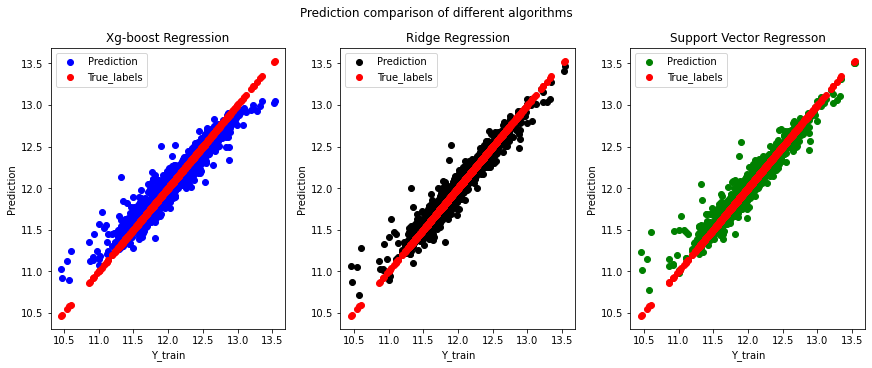

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 5),sharex=True,constrained_layout=True)
fig.suptitle('Prediction comparison of different algorithms')
ax1.scatter(y_target,xgboost_preds,c = 'blue',label='Prediction')
ax1.scatter(y_target,y_target,c='red',label='True_labels')
ax1.set_title('Xg-boost Regression')
ax1.set(xlabel='Y_train', ylabel='Prediction')
ax1.legend()

ax2.scatter(y_target,ridge_preds,c='black',label='Prediction')
ax2.scatter(y_target,y_target,c='red',label='True_labels')
ax2.set_title('Ridge Regression')
ax2.set(xlabel='Y_train', ylabel='Prediction')
ax2.legend()

ax3.scatter(y_target,svr_preds,c='green',label='Prediction')
ax3.scatter(y_target,y_target,c='red',label='True_labels')
ax3.set_title('Support Vector Regresson')
ax3.set(xlabel='Y_train',ylabel='Prediction')
ax3.legend()

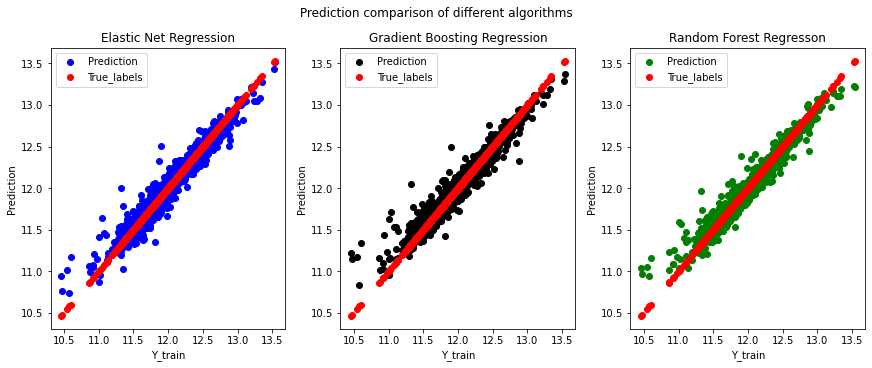

In [106]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 5),sharex=True,constrained_layout=True)
fig.suptitle('Prediction comparison of different algorithms')
ax1.scatter(y_target,elastic_preds,c = 'blue',label='Prediction')
ax1.scatter(y_target,y_target,c='red',label='True_labels')
ax1.set_title('Elastic Net Regression')
ax1.set(xlabel='Y_train', ylabel='Prediction')
ax1.legend()

ax2.scatter(y_target,gboost_preds,c='black',label='Prediction')
ax2.scatter(y_target,y_target,c='red',label='True_labels')
ax2.set_title('Gradient Boosting Regression')
ax2.set(xlabel='Y_train', ylabel='Prediction')
ax2.legend()

ax3.scatter(y_target,random_preds,c='green',label='Prediction')
ax3.scatter(y_target,y_target,c='red',label='True_labels')
ax3.set_title('Random Forest Regresson')
ax3.set(xlabel='Y_train',ylabel='Prediction')
ax3.legend()

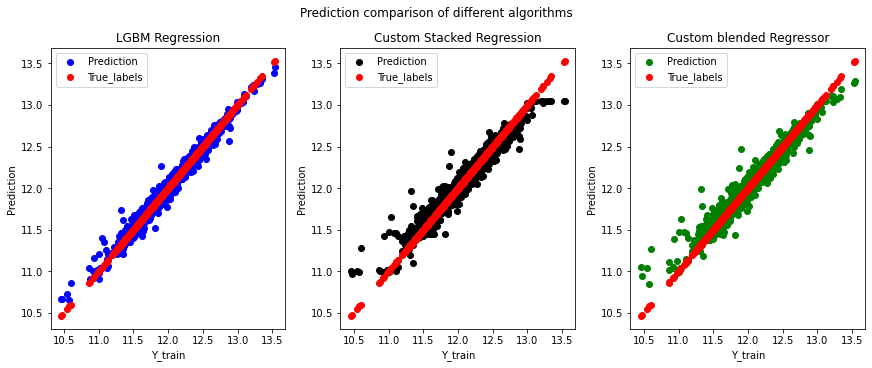

In [107]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 5),sharex=True,constrained_layout=True)
fig.suptitle('Prediction comparison of different algorithms')
ax1.scatter(y_target,gbm_preds,c = 'blue',label='Prediction')
ax1.scatter(y_target,y_target,c='red',label='True_labels')
ax1.set_title('LGBM Regression')
ax1.set(xlabel='Y_train', ylabel='Prediction')
ax1.legend()

ax2.scatter(y_target,stacked_preds,c='black',label='Prediction')
ax2.scatter(y_target,y_target,c='red',label='True_labels')
ax2.set_title('Custom Stacked Regression')
ax2.set(xlabel='Y_train', ylabel='Prediction')
ax2.legend()

ax3.scatter(y_target,blended_preds,c='green',label='Prediction')
ax3.scatter(y_target,y_target,c='red',label='True_labels')
ax3.set_title('Custom blended Regressor')
ax3.set(xlabel='Y_train',ylabel='Prediction')
ax3.legend()

In [108]:
scores

{'xgboost': (0.13895108339630197, 0.017632822415395835),
 'ridge': (0.11008698864918842, 0.014153101703519853),
 'svr': (0.10912094055150032, 0.013777937845821986),
 'elastic': (0.11116419735079115, 0.013869253100625074),
 'g_boost': (0.12164036445940674, 0.01773623308330679),
 'random_forest': (0.13719908031157677, 0.016844974046899438),
 'gbm': (0.11962001875436626, 0.016307802831926947),
 'blended': (0.08737647290931681, 0)}

# Thats all for this project. 
It is clear that adding custom weights and blending the results works better than standalone regression methods.

In [224]:
submission3 =pd.read_csv('sample_submission.csv')
submission3.head()
submission3= submission3[['Id','SalePrice']]

In [229]:
submission3.set_index("Id",inplace=True)
submission3.head()

,SalePrice
Id,
1461,118688.0
1462,157261.0
1463,186992.0
1464,197650.0
1465,190356.0


In [230]:
submission3['SalePrice'] = np.floor(np.expm1(blended_predictions(test_data)))

In [231]:
submission3.head()

,SalePrice
Id,
1461,118688.0
1462,157261.0
1463,186992.0
1464,197650.0
1465,190356.0


In [232]:
submission3.to_csv('sample_submission.csv')